In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train,y_train_sparse),(x_test,y_test_sparse)=fashion_mnist.load_data()
print(x_train.shape,x_test.shape)
from tensorflow.keras.utils import to_categorical, plot_model
y_train=to_categorical(y_train_sparse)
y_test=to_categorical(y_test_sparse)
print(y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(10000, 10)


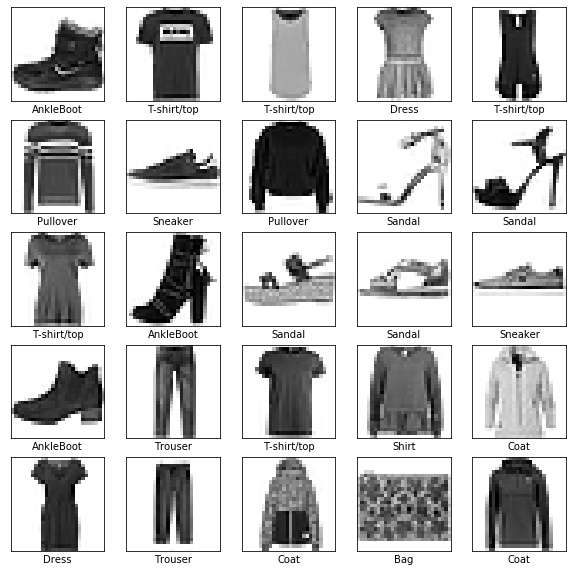

In [2]:
x_train=x_train/255.0
x_test=x_test/255.0

class_names=['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','AnkleBoot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_sparse[i]])
plt.show()

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,LeakyReLU,PReLU,BatchNormalization

model=Sequential()

model.add(Flatten(input_shape=[28,28]))
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))

model.add(BatchNormalization(momentum=0.9))
model.add(Dense(128,activation='selu',kernel_initializer='lecun_normal'))

model.add(BatchNormalization(center=False, scale=False))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               256       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 236,426
Trainable params: 235,658
Non-trainable params: 768
________________________________________________

* 5-1 에서는 categorical crossentropy 사용함.
* 여기 5-2에서는 loss 함수를 정의해버림.

In [4]:
#@tf.function
def sse_linear_loss(y_true,y_pred):
    error=tf.abs(y_true-y_pred)
    is_error=error<0.3
    error_1=tf.reduce_sum(tf.square(error))
    error_2=tf.reduce_sum(error)
    return tf.where(is_error, error_1,error_2)   

In [5]:
model.compile(loss=sse_linear_loss, optimizer='nadam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 15s 307us/sample - loss: 8.4621 - accuracy: 0.8254 - val_loss: 7.1086 - val_accuracy: 0.8503
Epoch 2/10
48000/48000 [==============================] - 11s 230us/sample - loss: 6.6696 - accuracy: 0.8619 - val_loss: 6.4960 - val_accuracy: 0.8646
Epoch 3/10
48000/48000 [==============================] - 12s 251us/sample - loss: 6.0514 - accuracy: 0.8745 - val_loss: 6.4730 - val_accuracy: 0.8653
Epoch 4/10
48000/48000 [==============================] - 13s 271us/sample - loss: 5.6198 - accuracy: 0.8842 - val_loss: 5.9698 - val_accuracy: 0.8782
Epoch 5/10
48000/48000 [==============================] - 13s 268us/sample - loss: 5.2810 - accuracy: 0.8924 - val_loss: 5.9584 - val_accuracy: 0.8761
Epoch 6/10
48000/48000 [==============================] - 12s 258us/sample - loss: 5.0502 - accuracy: 0.8957 - val_loss: 5.5367 - val_accuracy: 0.8861
Epoch 7/10
48000/48000 [====================

* parent class 'Loss' 를 사용해 loss함수 정의

In [6]:
class SseLinearLoss(tf.keras.losses.Loss):
    def __init__(self,threshold=0.3,**kwargs):
        self.threshold=threshold
        super().__init__(**kwargs)
    def call(self,y_true,y_pred):
        error=tf.abs(y_true-y_pred)
        is_error=error<self.threshold
        error_1=tf.reduce_sum(tf.square(error))
        error_2=tf.reduce_sum(error)
        return tf.where(is_error, error_1,error_2)
    def get_config(self):
        base_config=super().get_config()
        return {**base_config, 'threshold':self.threshold} #dictionry 형태로 설명할 수 있도록 등록

In [7]:
model.compile(loss=SseLinearLoss(0.4), optimizer='nadam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 14s 298us/sample - loss: 4.0969 - accuracy: 0.9165 - val_loss: 5.6233 - val_accuracy: 0.8846
Epoch 2/10
48000/48000 [==============================] - 13s 264us/sample - loss: 4.0170 - accuracy: 0.9180 - val_loss: 5.3727 - val_accuracy: 0.8887
Epoch 3/10
48000/48000 [==============================] - 13s 271us/sample - loss: 3.8941 - accuracy: 0.9206 - val_loss: 5.4805 - val_accuracy: 0.8887
Epoch 4/10
48000/48000 [==============================] - 13s 263us/sample - loss: 3.6856 - accuracy: 0.9251 - val_loss: 5.1599 - val_accuracy: 0.8925
Epoch 5/10
48000/48000 [==============================] - 13s 262us/sample - loss: 3.6473 - accuracy: 0.9261 - val_loss: 5.2279 - val_accuracy: 0.8942
Epoch 6/10
48000/48000 [==============================] - 12s 259us/sample - loss: 3.5477 - accuracy: 0.9281 - val_loss: 5.2001 - val_accuracy: 0.8944
Epoch 7/10
48000/48000 [====================

# Boston Housing Data

13개 feature variable

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
(x_train,y_train),(x_test,y_test)=boston_housing.load_data()
print(x_train.dtype,y_train.dtype)
print(x_train.shape,y_train.shape)
print(x_test.shape)

float64 float64
(404, 13) (404,)
(102, 13)


* input이 들어옴 -> dense 로 물고 늘어짐
* recon = Dense(13,...) ??
    * recon 원래있는 특성변수를  copy, 재생산하겠다. recon_loss = tf.reduce_mean(tf.square(input_A-recon)) 를 5%만 곱해서 더함.
* pca : 원래 x가 가지고있는 informatin 을 minimize. 
    * dense 초반 3번이 이 역할을 수행.
    * 이를 통해 h3는 아무도 모름. 암호화. input은 모름. (??)
    
* 원래의 input을 되살려 내는것: 언제 사용?
    * pca 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           448         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           1056        dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 32)           1056        dense_4[0][0]                    
______________________________________________________________________________________________

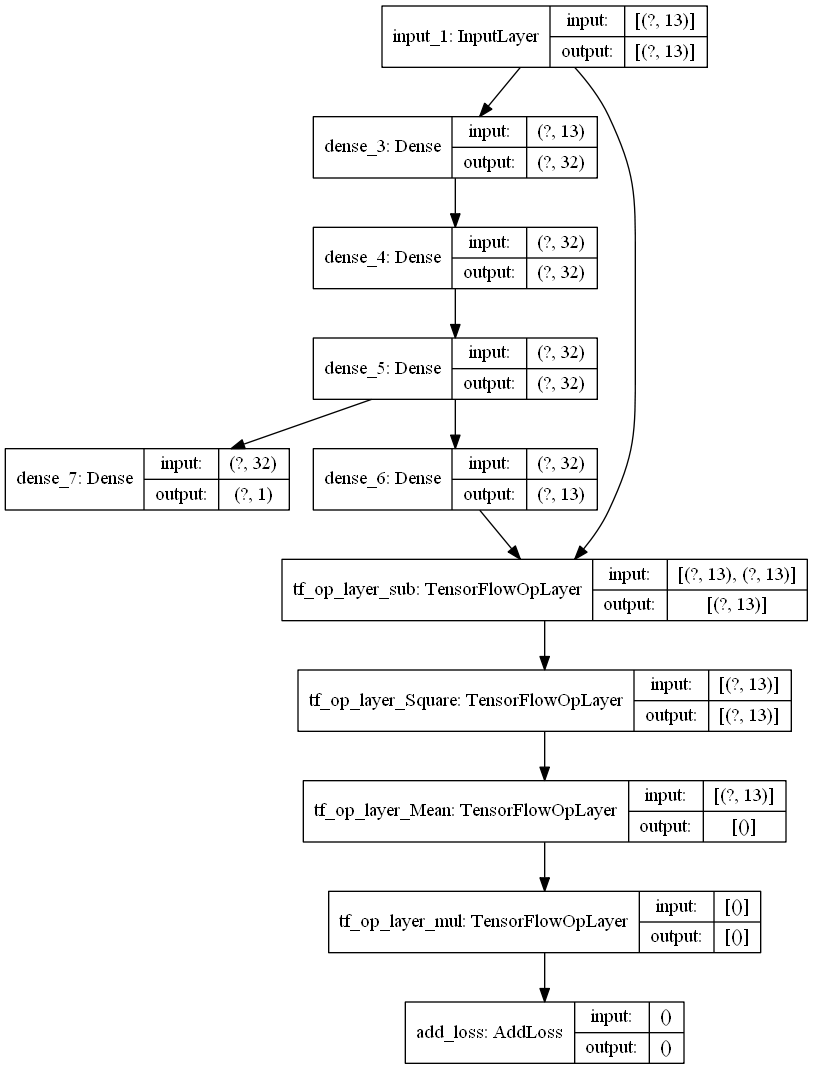

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as k

input_A=Input(shape=[13])
h1=Dense(32,activation='elu',kernel_initializer='he_normal')(input_A)
h2=Dense(32,activation='elu',kernel_initializer='he_normal')(h1)
h3=Dense(32,activation='elu',kernel_initializer='he_normal')(h2)
recon=Dense(13,activation='elu',kernel_initializer='he_normal')(h3) #dense6 #input을 되살려서 비교하겠다. input의 size와 같음.
out1=Dense(1)(h3) #dense7 #model output 

model=Model(input_A,out1)

recon_loss=tf.reduce_mean(tf.square(input_A-recon)) #병렬 형태 -> 끝나고 나서 loss를 정의. x를 다시 reconstruction 하고싶은거.
#loss 계산할 때 input과의 차이를 줄이는 방향으로. input을 되살린다는 뜻. 
#이걸 원래 loss에 더함.
model.add_loss(0.05*recon_loss)
model.summary()
plot_model(model,show_shapes=True)

In [10]:
model.compile(loss='mse',optimizer='nadam')
history=model.fit(x_train,y_train,epochs=10, batch_size=32, validation_data=(x_test,y_test))

Train on 404 samples, validate on 102 samples
Epoch 1/10
404/404 [==============================] - 1s 4ms/sample - loss: 15864.3012 - val_loss: 1863.1023
Epoch 2/10
404/404 [==============================] - 0s 156us/sample - loss: 1159.2921 - val_loss: 1060.0739
Epoch 3/10
404/404 [==============================] - 0s 183us/sample - loss: 872.9136 - val_loss: 772.8971
Epoch 4/10
404/404 [==============================] - 0s 207us/sample - loss: 680.6057 - val_loss: 676.6420
Epoch 5/10
404/404 [==============================] - 0s 183us/sample - loss: 592.7765 - val_loss: 598.9943
Epoch 6/10
404/404 [==============================] - 0s 156us/sample - loss: 517.8888 - val_loss: 533.4703
Epoch 7/10
404/404 [==============================] - 0s 151us/sample - loss: 454.4086 - val_loss: 465.5961
Epoch 8/10
404/404 [==============================] - 0s 163us/sample - loss: 397.7938 - val_loss: 409.8646
Epoch 9/10
404/404 [==============================] - 0s 188us/sample - loss: 348.3596 

위의 모델 전체를 class 로 만들수가 있음. (p.130)

In [11]:
class ReconReg(tf.keras.models.Model):
    def __init__(self,input_dim,out_dim,**kwargs):
        super().__init__(**kwargs) #built-in 을 등록
        self.hidden=[Dense(32,activation='elu',kernel_initializer='he_normal') for _ in range(3)] #모형의 리스트 / 3번 반복 / 3개의 히든층
        self.out=Dense(out_dim)
        self.recon=Dense(input_dim)
        
    def call(self,inputs):
        z=inputs
        for layer in self.hidden:
            z=layer(z)
        recon=self.recon(z)
        recon_loss=tf.reduce_mean(tf.square(recon-inputs))
        self.add_loss(0.05*recon_loss)
        return self.out(z) #output을 return함

In [12]:
model=ReconReg(13,1)
model.compile( loss='mse',optimizer='nadam')
history=model.fit(x_train,y_train,epochs=10, batch_size=32, validation_data=(x_test,y_test)) #fit() 할 때 call 이 불림. 여기의 praram들이 input으로 들어감.

Train on 404 samples, validate on 102 samples
Epoch 1/10
404/404 [==============================] - 1s 3ms/sample - loss: 38214.7240 - val_loss: 13655.7807
Epoch 2/10
404/404 [==============================] - 0s 131us/sample - loss: 8323.0124 - val_loss: 3781.4896
Epoch 3/10
404/404 [==============================] - 0s 128us/sample - loss: 2972.8196 - val_loss: 2244.8419
Epoch 4/10
404/404 [==============================] - 0s 116us/sample - loss: 1946.7101 - val_loss: 1632.9675
Epoch 5/10
404/404 [==============================] - 0s 126us/sample - loss: 1436.0726 - val_loss: 1227.9101
Epoch 6/10
404/404 [==============================] - 0s 121us/sample - loss: 1083.6974 - val_loss: 934.1043
Epoch 7/10
404/404 [==============================] - 0s 118us/sample - loss: 832.5086 - val_loss: 724.6221
Epoch 8/10
404/404 [==============================] - 0s 146us/sample - loss: 645.5722 - val_loss: 570.8897
Epoch 9/10
404/404 [==============================] - 0s 143us/sample - loss: 5

In [13]:
model.summary()

Model: "recon_reg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              multiple                  448       
_________________________________________________________________
dense_9 (Dense)              multiple                  1056      
_________________________________________________________________
dense_10 (Dense)             multiple                  1056      
_________________________________________________________________
dense_11 (Dense)             multiple                  33        
_________________________________________________________________
dense (Dense)                multiple                  429       
Total params: 3,022
Trainable params: 3,022
Non-trainable params: 0
_________________________________________________________________


In [1]:
#p.131

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train,y_train_sparse),(x_test,y_test_sparse)=fashion_mnist.load_data()
print(x_train.shape,x_test.shape)

from tensorflow.keras.utils import to_categorical, plot_model

y_train=to_categorical(y_train_sparse)
y_test=to_categorical(y_test_sparse)
print(y_test.shape)
x_train=x_train/255.0
x_test=x_test/255.0

(60000, 28, 28) (10000, 28, 28)
(10000, 10)


In [4]:
#p.131 def_sampling 부분 (4/6 2:44분 설명)

In [2]:
# hidden layer 가 많을 수록 input의 특징이 날라가버림.
# 그래서 concatenate 많이 씀. diminish 현상 완화, residual connection.

In [16]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self,nlayers,n_nodes,**kwargs):
        super().__init__(**kwargs)
        self.hidden=[tf.keras.layers.Dense(n_nodes,activation='elu',kernel_initializer='he_normal') for _ in range(nlayers)]
    def call(self,inputs):
        z=inputs
        for layer in self.hidden:
            z=layer(z)
        return tf.concat([inputs,z], axis=-1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               200960    
_________________________________________________________________
residual_block (ResidualBloc (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 256)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

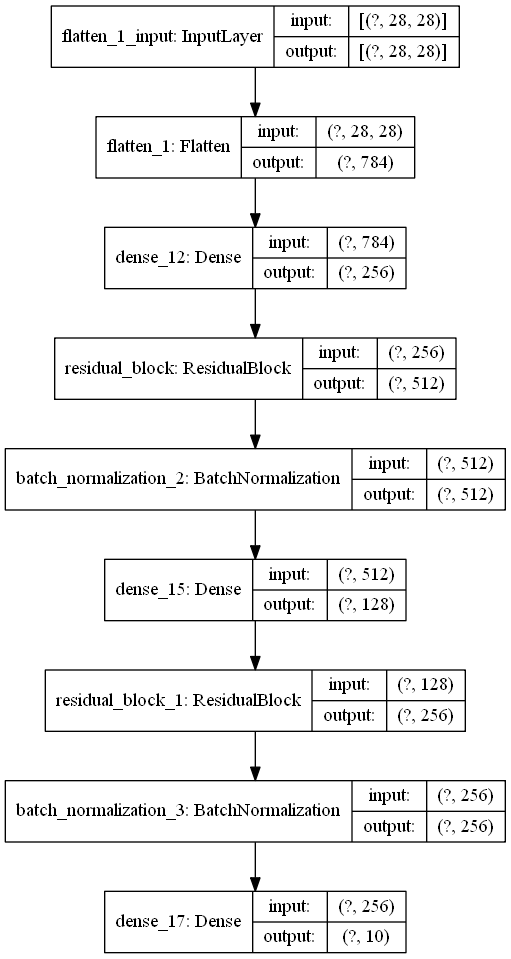

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,BatchNormalization

model=Sequential()
model.add(Flatten(input_shape=[28,28]))
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(ResidualBlock(2,256)) #node가 256개인 걸로 2번 돌음 -> concatenate니까 output 노드 수 512됨
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(ResidualBlock(1,128))
model.add(BatchNormalization(center=False, scale=False))
model.add(Dense(10,activation='softmax'))
model.summary()
plot_model(model,show_shapes=True)

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='nadam', metrics=['accuracy'])
results=model.fit(x_train,y_train, batch_size=32, epochs=10,validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 22s 412us/sample - loss: 0.4612 - accuracy: 0.8334 - val_loss: 0.4128 - val_accuracy: 0.8538
Epoch 2/10
54000/54000 [==============================] - 19s 357us/sample - loss: 0.3604 - accuracy: 0.8686 - val_loss: 0.3593 - val_accuracy: 0.8680
Epoch 3/10
54000/54000 [==============================] - 18s 338us/sample - loss: 0.3247 - accuracy: 0.8815 - val_loss: 0.3382 - val_accuracy: 0.8727
Epoch 4/10
54000/54000 [==============================] - 19s 344us/sample - loss: 0.3029 - accuracy: 0.8874 - val_loss: 0.3455 - val_accuracy: 0.8800
Epoch 5/10
54000/54000 [==============================] - 23s 424us/sample - loss: 0.2814 - accuracy: 0.8959 - val_loss: 0.3359 - val_accuracy: 0.8782
Epoch 6/10
54000/54000 [==============================] - 20s 379us/sample - loss: 0.2640 - accuracy: 0.9015 - val_loss: 0.3011 - val_accuracy: 0.8895
Epoch 7/10
54000/54000 [=====================

### add dense
* parent layer 를 완전히 새로 만들음
* built-in 형식과 완벽히 똑같이 만들음. 구성 그대로.

In [3]:
# p.135

In [19]:
class AddDense(tf.keras.layers.Layer):
    def __init__(self,nodes,activation=None,**kwargs):  
        super().__init__(**kwargs) # node 와 activation function 이 들어옴
        self.nodes=nodes
        self.activation=tf.keras.activations.get(activation)
        
    def build(self, batch_input_shape): # dense를 만들어 놓음. add_weight 를 집어넣음. build의 역할.
        self.W=self.add_weight(shape=[batch_input_shape[-1],self.nodes])
        self.b=self.add_weight(shape=[self.nodes,])
        super().build(batch_input_shape)
        
    def call(self,x): # x가 불려지면 x의 shape이 build 함수에서의 input_shape 임 
        return self.activation(x@self.W+self.b) # @ 는 matrix의 multiplication임
    
    def compute_output_shape(self,batch_input_shape): #output shape을 정의
        return tf.TensorShape.as_list([batch_input_shape[:-1],self.nodes])
    
    def get_config(self):
        base_config=super.get_config()
        return {**base_config, 'nodes':self.nodes,'activation':tf.keras.activations(self.activation)}

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,LeakyReLU,PReLU,BatchNormalization

model=Sequential()
model.add(Flatten(input_shape=[28,28]))
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(AddDense(256,activation='relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(AddDense(64,activation='relu'))
model.add(BatchNormalization(center=False, scale=False))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               200960    
_________________________________________________________________
add_dense (AddDense)         (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
add_dense_1 (AddDense)       (None, 64)                8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)               

In [21]:
model.compile(loss='categorical_crossentropy',optimizer='nadam', metrics=['accuracy'])
results=model.fit(x_train,y_train, batch_size=32, epochs=10,validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 17s 321us/sample - loss: 0.4901 - accuracy: 0.8261 - val_loss: 0.4321 - val_accuracy: 0.8442
Epoch 2/10
54000/54000 [==============================] - 15s 277us/sample - loss: 0.3898 - accuracy: 0.8594 - val_loss: 0.3740 - val_accuracy: 0.8623
Epoch 3/10
54000/54000 [==============================] - 15s 272us/sample - loss: 0.3537 - accuracy: 0.8713 - val_loss: 0.3997 - val_accuracy: 0.8623
Epoch 4/10
54000/54000 [==============================] - 17s 321us/sample - loss: 0.3284 - accuracy: 0.8805 - val_loss: 0.3258 - val_accuracy: 0.8825
Epoch 5/10
54000/54000 [==============================] - 17s 307us/sample - loss: 0.3092 - accuracy: 0.8857 - val_loss: 0.3228 - val_accuracy: 0.8840
Epoch 6/10
54000/54000 [==============================] - 16s 289us/sample - loss: 0.2906 - accuracy: 0.8929 - val_loss: 0.3352 - val_accuracy: 0.8777
Epoch 7/10
54000/54000 [=====================